# Simulation sans pannes

In [3]:

import wntr
import pandas as pd
import matplotlib.pyplot as plt
import copy



In [4]:

########## Configuration ##########
# Fichiers d'entrée/sortie
INP_FILE = "CTOWN.INP"
DEMAND_PATTERNS_PATH = "three_year_demands_ctown.csv"
STARTING_DEMAND_PATH = "starting_demand_points.csv"
INITIAL_TANK_LEVELS_PATH = "tank_initial_conditions.csv"
SIMULATION_DAYS = 5
WEEK_INDEX = 0

In [5]:
def prepare_model(wn):
    # Charge les données externes
    total_demands = pd.read_csv(DEMAND_PATTERNS_PATH, index_col=0)
    demand_starting_points = pd.read_csv(STARTING_DEMAND_PATH, index_col=0)
    initial_tank_levels = pd.read_csv(INITIAL_TANK_LEVELS_PATH, index_col=0)
    
    # Applique les demandes
    week_start = demand_starting_points.iloc[WEEK_INDEX][0]
    limit = (SIMULATION_DAYS * 24) - 1
    week_demands = total_demands.loc[week_start:week_start + limit, :]
    
    for name, pat in wn.patterns():
        pat.multipliers = week_demands[name].values.tolist()
    
    # Définit les niveaux initiaux des réservoirs
    for i in range(1, 8):
        wn.get_node(f'T{i}').init_level = float(
            initial_tank_levels.iloc[WEEK_INDEX][f'T{i}']
        )
    
    return wn

In [6]:
########## Simulation ##########
def run_simulation(wn_original, use_wntr=False):
    # Crée une copie profonde du modèle
    wn = copy.deepcopy(wn_original)
    wn = prepare_model(wn)
    wn.options.time.duration = SIMULATION_DAYS * 24 * 3600
    
    if use_wntr:
        print("Running WNTR simulation (PDD mode)...")
        # Configuration du modèle PDD
        wn.options.hydraulic.demand_model = 'PDD'
        sim = wntr.sim.WNTRSimulator(wn)
    else:
        print("Running EPANET simulation...")
        sim = wntr.sim.EpanetSimulator(wn)
    
    return sim.run_sim()

d:\Geforce\anaconda\Lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "CTOWN.INP"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))



=== Running simulations ===


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2128\3850354147.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_start = demand_starting_points.iloc[WEEK_INDEX][0]


Running EPANET simulation...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2128\3850354147.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_start = demand_starting_points.iloc[WEEK_INDEX][0]


Running WNTR simulation (PDD mode)...

=== Generating comparison plots ===


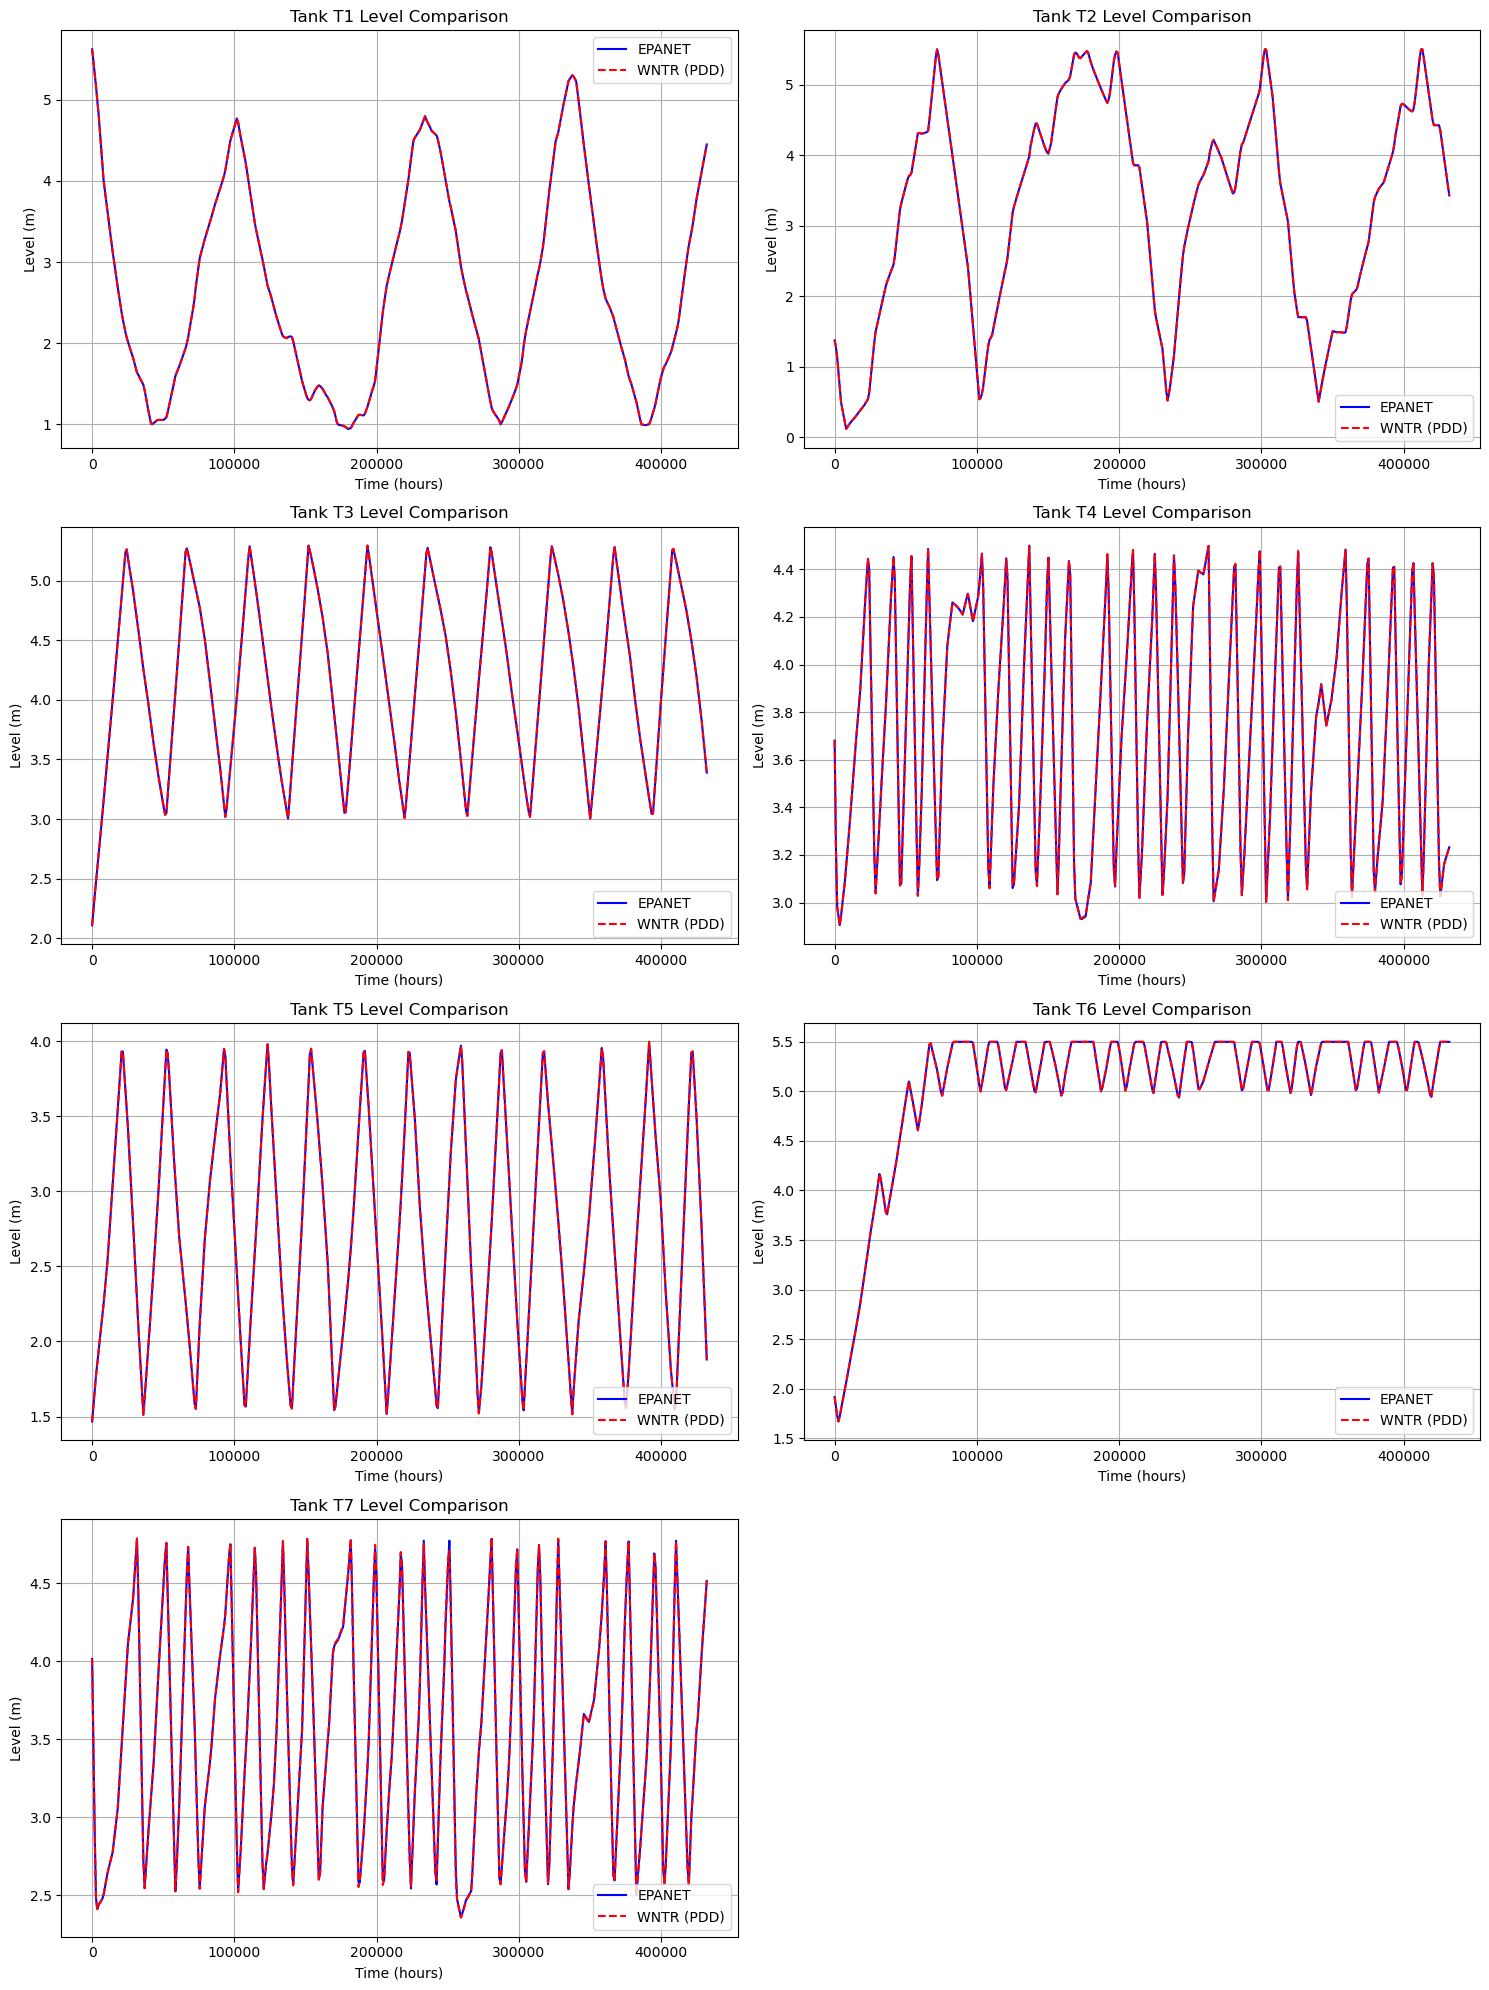


=== Saving results ===
Done!


In [7]:
########## Exécution principale ##########
if __name__ == "__main__":
    # Charge le réseau
    wn_original = wntr.network.WaterNetworkModel(INP_FILE)
    
    # Lance les simulations
    print("\n=== Running simulations ===")
    epanet_results = run_simulation(wn_original, use_wntr=False)
    wntr_results = run_simulation(wn_original, use_wntr=True)
    
    # Visualisation
    def plot_tank_levels(epanet_res, wntr_res):
        plt.figure(figsize=(15, 20))
        tanks = [f'T{i}' for i in range(1, 8)]
        
        for i, tank in enumerate(tanks, 1):
            plt.subplot(4, 2, i)
            epanet_res.node['pressure'][tank].plot(
                label='EPANET', color='blue', linestyle='-'
            )
            wntr_res.node['pressure'][tank].plot(
                label='WNTR (PDD)', color='red', linestyle='--'
            )
            
            plt.title(f"Tank {tank} Level Comparison")
            plt.xlabel('Time (hours)')
            plt.ylabel('Level (m)')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    print("\n=== Generating comparison plots ===")
    plot_tank_levels(epanet_results, wntr_results)
    
    # Sauvegarde
    print("\n=== Saving results ===")
    epanet_results.node['pressure'].to_csv("epanet_results.csv")
    wntr_results.node['pressure'].to_csv("wntr_results.csv")
    print("Done!")

In [8]:
########## Post-traitement et visualisation ##########
def load_and_analyze_results():
    # Chargement des résultats sauvegardés
    print("\nLoading saved results...")
    epanet_results = pd.read_csv("epanet_results.csv", index_col=0)
    wntr_results = pd.read_csv("wntr_results.csv", index_col=0)
    
    
    # 1. Affichage des données brutes sous forme de tableau
    print("\n=== Raw Data Preview ===")
    print("\nEPANET Results (first 5 timesteps):")
    display(epanet_results.head())
    
    print("\nWNTR Results (first 5 timesteps):")
    display(wntr_results.head())
    
    # Analyse statistique supplémentaire
    print("\n=== Statistical comparison ===")
    diff = epanet_results - wntr_results
    stats = pd.DataFrame({
        'Max Difference (m)': diff.max(),
        'Mean Difference (m)': diff.mean(),
        'Std Deviation (m)': diff.std()
    })
    print(stats.round(3))

In [9]:
# Exécution du post-traitement
if __name__ == "__main__":
    load_and_analyze_results()
    print("\nAnalysis completed!")


Loading saved results...

=== Raw Data Preview ===

EPANET Results (first 5 timesteps):


,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J317,J323,R1,T3,T1,T7,T6,T5,T2,T4
0,29.648296,63.339233,37.906280,59.973106,82.37311,34.88523,28.072023,25.195501,48.027030,43.949875,...,54.416794,54.416794,-0.000001,2.109873,5.622004,4.015036,1.915250,1.466811,1.373781,3.680608
900,29.205767,63.197052,37.764100,59.530586,81.93059,34.74305,27.984642,25.106958,47.555904,43.478750,...,54.005356,54.005356,-0.000001,2.235875,5.474883,3.456689,1.822456,1.570646,1.281843,3.238068
1800,30.388737,63.054980,37.622030,82.742226,97.69934,34.60098,24.361881,22.373892,47.085545,43.008396,...,53.590740,53.590740,-0.000001,2.356900,5.327869,2.903001,1.726229,1.673700,1.133396,2.982530
2700,30.350012,60.959940,35.526990,82.666120,97.64190,32.50594,24.166159,22.173422,52.757270,48.680115,...,65.385500,65.385500,-0.000001,2.472595,5.172143,2.481213,1.668949,1.770485,0.919130,2.944198
3600,30.342665,62.381374,36.957157,83.500190,98.63922,33.93651,23.973152,21.975070,53.041393,48.954433,...,66.495200,66.495200,-0.000001,2.587695,4.992564,2.410771,1.722713,1.851364,0.705259,2.905419



WNTR Results (first 5 timesteps):


,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J317,J323,T3,T1,T7,T6,T5,T2,T4,R1
0,29.648278,63.339142,37.906188,59.973005,82.373005,34.885139,28.072759,25.196053,48.026961,43.949812,...,54.416720,54.416720,2.109871,5.622006,4.015033,1.915251,1.466813,1.373781,3.680605,0.0
900,29.205738,63.196964,37.764010,59.530465,81.930465,34.742962,27.984756,25.107078,47.555493,43.478344,...,54.004359,54.004359,2.235552,5.474881,3.456683,1.822454,1.570647,1.281982,3.238065,0.0
1800,30.388276,63.054891,37.621937,82.742118,97.699072,34.600888,24.362056,22.374095,47.085246,43.008098,...,53.590206,53.590206,2.356593,5.327870,2.903000,1.726230,1.673698,1.133674,2.982075,0.0
2700,30.349559,60.959859,35.526905,82.666006,97.641626,32.505856,24.166329,22.173621,52.756743,48.679595,...,65.385198,65.385198,2.472284,5.172177,2.480662,1.668774,1.770512,0.919407,2.943740,0.0
3600,30.343953,62.381333,36.957112,83.512271,98.653069,33.936462,23.973980,21.975760,53.042174,48.955215,...,66.495829,66.495829,2.587389,4.992596,2.410223,1.722536,1.851386,0.705534,2.904964,0.0



=== Statistical comparison ===
       Max Difference (m)  Mean Difference (m)  Std Deviation (m)
J1                  0.410               -0.015              0.359
J10                 0.504               -0.008              0.223
J101                0.420               -0.013              0.300
J102                0.416               -0.014              0.323
J1024               0.434               -0.009              0.222
...                   ...                  ...                ...
T3                  0.002                0.000              0.001
T4                  0.010               -0.000              0.005
T5                  0.004               -0.000              0.001
T6                  0.015               -0.001              0.003
T7                  0.067                0.001              0.012

[396 rows x 3 columns]

Analysis completed!


# Simulation des pannes

In [10]:
# # Simulation avec Gestion des Pannes

import wntr
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns




In [20]:
########## Configuration ##########
# Fichiers d'entrée/sortie
INP_FILE = "CTOWN.INP"
DEMAND_PATTERNS_PATH = "three_year_demands_ctown.csv"
STARTING_DEMAND_PATH = "starting_demand_points.csv"
INITIAL_TANK_LEVELS_PATH = "tank_initial_conditions.csv"
SIMULATION_DAYS = 5
WEEK_INDEX = 0

# Configuration des pannes
FAILURE_SCENARIOS = {
    'pipe_break': {
        'type': 'pipe',
        'component': 'P10',  # ID de la conduite
        'start_time': 49,   # heure de début (h)
        'duration': 1,      # durée (h)
        'severity': 0.5     # réduction du débit (0=fermé, 1=normal)
    },
    'pump_failure': {
        'type': 'pump',
        'component': 'PU1',
        'start_time': 24,
        'duration': 2,
        'severity': 0.0     # 0=arrêt complet
    },
    'tank_contamination': {
        'type': 'tank',
        'component': 'T5',
        'start_time': 72,
        'duration': 5,
        'action': 'isolate'  # isolation du réservoir
    }
}

In [21]:
class FailureManager:
    """Gestionnaire des pannes pour le réseau d'eau"""
    
    def __init__(self, wn):
        self.wn = wn
        self.original_components = {}
        self.active_failures = {}
        
    def store_original_state(self):
        """Sauvegarde l'état original des composants"""
        # Sauvegarder les propriétés des conduites
        for pipe_name, pipe in self.wn.pipes():
            self.original_components[pipe_name] = {
                'roughness': pipe.roughness,
                'diameter': pipe.diameter,
                'status': pipe.initial_status
            }
        
        # Sauvegarder les propriétés des pompes
        for pump_name, pump in self.wn.pumps():
            self.original_components[pump_name] = {
                'status': pump.initial_status,
                'speed': getattr(pump, 'speed', 1.0)
            }
            
        # Sauvegarder les propriétés des réservoirs
        for tank_name, tank in self.wn.tanks():
            self.original_components[tank_name] = {
                'init_level': tank.init_level,
                'min_level': tank.min_level,
                'max_level': tank.max_level
            }
    
    def apply_pipe_failure(self, pipe_id, severity, description=""):
        """Applique une panne sur une conduite"""
        if pipe_id in self.wn.pipe_name_list:
            pipe = self.wn.get_link(pipe_id)
            if severity == 0:
                # Fermeture complète
                pipe.initial_status = wntr.network.LinkStatus.Closed
                status_desc = "fermée"
            else:
                # Réduction du diamètre pour simuler une obstruction partielle
                original_diameter = self.original_components[pipe_id]['diameter']
                pipe.diameter = original_diameter * np.sqrt(severity)
                status_desc = f"obstruée à {(1-severity)*100:.0f}%"
            
            print(f"Panne appliquée: Conduite {pipe_id} {status_desc} - {description}")
            return True
        return False
    
    def apply_pump_failure(self, pump_id, severity, description=""):
        """Applique une panne sur une pompe"""
        if pump_id in self.wn.pump_name_list:
            pump = self.wn.get_link(pump_id)
            if severity == 0:
                pump.initial_status = wntr.network.LinkStatus.Closed
                status_desc = "arrêtée"
            else:
                # Réduction de la vitesse/efficacité
                if hasattr(pump, 'speed'):
                    pump.speed = severity
                status_desc = f"efficacité réduite à {severity*100:.0f}%"
            
            print(f"Panne appliquée: Pompe {pump_id} {status_desc} - {description}")
            return True
        return False
    
    def apply_tank_failure(self, tank_id, action, description=""):
        """Applique une panne sur un réservoir"""
        if tank_id in self.wn.tank_name_list:
            tank = self.wn.get_node(tank_id)
            if action == 'isolate':
                # Isolation: fixer le niveau minimal très haut pour empêcher l'utilisation
                tank.min_level = tank.max_level * 0.99
                status_desc = "isolé"
            elif action == 'leak':
                # Fuite: réduire le niveau maximal
                tank.max_level = tank.max_level * 0.5
                status_desc = "en fuite"
            
            print(f"Panne appliquée: Réservoir {tank_id} {status_desc} - {description}")
            return True
        return False
    
    def restore_component(self, component_id):
        """Restaure un composant à son état original"""
        if component_id in self.original_components:
            original = self.original_components[component_id]
            
            # Restaurer selon le type de composant
            if component_id in self.wn.pipe_name_list:
                pipe = self.wn.get_link(component_id)
                pipe.roughness = original['roughness']
                pipe.diameter = original['diameter']
                pipe.initial_status = original['status']
                
            elif component_id in self.wn.pump_name_list:
                pump = self.wn.get_link(component_id)
                pump.initial_status = original['status']
                if 'speed' in original:
                    pump.speed = original['speed']
                    
            elif component_id in self.wn.tank_name_list:
                tank = self.wn.get_node(component_id)
                tank.init_level = original['init_level']
                tank.min_level = original['min_level']
                tank.max_level = original['max_level']
            
            print(f"Composant {component_id} restauré")
            if component_id in self.active_failures:
                del self.active_failures[component_id]
            return True
        return False

In [22]:
def prepare_model(wn):
    """Prépare le modèle avec les demandes et niveaux initiaux"""
    # Charge les données externes
    total_demands = pd.read_csv(DEMAND_PATTERNS_PATH, index_col=0)
    demand_starting_points = pd.read_csv(STARTING_DEMAND_PATH, index_col=0)
    initial_tank_levels = pd.read_csv(INITIAL_TANK_LEVELS_PATH, index_col=0)
    
    # Applique les demandes
    week_start = demand_starting_points.iloc[WEEK_INDEX][0]
    limit = (SIMULATION_DAYS * 24) - 1
    week_demands = total_demands.loc[week_start:week_start + limit, :]
    
    for name, pat in wn.patterns():
        pat.multipliers = week_demands[name].values.tolist()
    
    # Définit les niveaux initiaux des réservoirs
    for i in range(1, 8):
        wn.get_node(f'T{i}').init_level = float(
            initial_tank_levels.iloc[WEEK_INDEX][f'T{i}']
        )
    
    return wn

# %%
def run_simulation_with_failures(wn_original, failure_scenarios=None, use_wntr=False):
    """Lance une simulation avec gestion des pannes"""
    # Crée une copie profonde du modèle
    wn = copy.deepcopy(wn_original)
    wn = prepare_model(wn)
    wn.options.time.duration = SIMULATION_DAYS * 24 * 3600
    
    # Initialise le gestionnaire de pannes
    failure_manager = FailureManager(wn)
    failure_manager.store_original_state()
    
    # Applique les pannes si spécifiées
    if failure_scenarios:
        print("\n=== Application des pannes ===")
        for scenario_name, scenario in failure_scenarios.items():
            component_id = scenario['component']
            failure_type = scenario['type']
            
            if failure_type == 'pipe':
                failure_manager.apply_pipe_failure(
                    component_id, 
                    scenario['severity'],
                    f"Scénario: {scenario_name}"
                )
            elif failure_type == 'pump':
                failure_manager.apply_pump_failure(
                    component_id,
                    scenario['severity'],
                    f"Scénario: {scenario_name}"
                )
            elif failure_type == 'tank':
                failure_manager.apply_tank_failure(
                    component_id,
                    scenario['action'],
                    f"Scénario: {scenario_name}"
                )
    
    # Configuration du simulateur
    if use_wntr:
        print("Running WNTR simulation with failures (PDD mode)...")
        wn.options.hydraulic.demand_model = 'PDD'
        sim = wntr.sim.WNTRSimulator(wn)
    else:
        print("Running EPANET simulation with failures...")
        sim = wntr.sim.EpanetSimulator(wn)
    
    try:
        results = sim.run_sim()
        return results, failure_manager
    except Exception as e:
        print(f"Erreur de simulation: {e}")
        return None, failure_manager

In [23]:
def analyze_failure_impact(normal_results, failure_results, failure_scenarios):
    """Analyse l'impact des pannes sur le réseau"""
    print("\n=== ANALYSE DE L'IMPACT DES PANNES ===")
    
    # Analyse des niveaux de réservoirs
    tanks = [f'T{i}' for i in range(1, 8)]
    
    print("\n1. Impact sur les niveaux des réservoirs:")
    for tank in tanks:
        if tank in normal_results.node['pressure'].columns and tank in failure_results.node['pressure'].columns:
            normal_levels = normal_results.node['pressure'][tank]
            failure_levels = failure_results.node['pressure'][tank]
            
            normal_min = normal_levels.min()
            failure_min = failure_levels.min()
            
            print(f"   {tank}: Niveau min normal={normal_min:.2f}m, avec pannes={failure_min:.2f}m")
            print(f"        Différence: {failure_min - normal_min:.2f}m ({((failure_min/normal_min-1)*100):+.1f}%)")
    
    # Analyse des pressions aux nœuds de demande
    print("\n2. Impact sur les pressions de service:")
    demand_nodes = [col for col in normal_results.node['pressure'].columns if col.startswith('J')]
    
    pressure_issues = 0
    for node in demand_nodes:
        if node in failure_results.node['pressure'].columns:
            failure_pressures = failure_results.node['pressure'][node]
            if (failure_pressures < 20).any():  # Seuil: 20m
                pressure_issues += 1
    
    print(f"   Nombre de jonctions affectées: {pressure_issues}/{len(demand_nodes)}")
    
    # Calcul des indicateurs de performance
    print("\n3. Indicateurs de performance:")
    
    # Fiabilité hydraulique (% du temps avec pression suffisante)
    total_nodes = len(demand_nodes)
    total_timesteps = len(failure_results.node['pressure'])
    
    sufficient_pressure_count = 0
    for node in demand_nodes:
        if node in failure_results.node['pressure'].columns:
            sufficient_pressure_count += (failure_results.node['pressure'][node] >= 20).sum()
    
    reliability = (sufficient_pressure_count / (total_nodes * total_timesteps)) * 100
    print(f"   Fiabilité hydraulique: {reliability:.1f}%")
    
    return {
        'reliability': reliability,
        'pressure_issues': pressure_issues,
        'total_nodes_analyzed': len(demand_nodes)
    }


In [24]:
def plot_failure_comparison(normal_results, failure_results, failure_scenarios):
    """Visualise la comparaison entre simulation normale et avec pannes"""
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Comparaison: Simulation Normale vs Avec Pannes', fontsize=16)
    
    tanks = [f'T{i}' for i in range(1, 8)]
    
    # Graphiques des niveaux de réservoirs
    for i, tank in enumerate(tanks):
        row = i // 3
        col = i % 3
        
        if tank in normal_results.node['pressure'].columns:
            normal_results.node['pressure'][tank].plot(
                ax=axes[row, col], label='Normal', color='blue', alpha=0.7
            )
            
        if tank in failure_results.node['pressure'].columns:
            failure_results.node['pressure'][tank].plot(
                ax=axes[row, col], label='Avec pannes', color='red', alpha=0.7, linestyle='--'
            )
        
        axes[row, col].set_title(f'Réservoir {tank}')
        axes[row, col].set_xlabel('Temps (heures)')
        axes[row, col].set_ylabel('Niveau (m)')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
        
        # Ajouter des annotations pour les pannes
        for scenario_name, scenario in failure_scenarios.items():
            if scenario.get('component') == tank:
                start_time = scenario.get('start_time', 0)
                duration = scenario.get('duration', 0)
                axes[row, col].axvspan(start_time, start_time + duration, 
                                     alpha=0.2, color='red', 
                                     label=f'Panne: {scenario_name}')
    
    # Supprimer les sous-graphiques vides
    if len(tanks) < 9:
        for i in range(len(tanks), 9):
            row = i // 3
            col = i % 3
            axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()

In [25]:
def create_failure_timeline(failure_scenarios, simulation_days):
    """Crée une timeline des pannes"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = {'pipe': 'red', 'pump': 'orange', 'tank': 'purple'}
    y_positions = {}
    y_pos = 0
    
    for scenario_name, scenario in failure_scenarios.items():
        component = scenario['component']
        failure_type = scenario['type']
        start_time = scenario.get('start_time', 0)
        duration = scenario.get('duration', 1)
        
        if component not in y_positions:
            y_positions[component] = y_pos
            y_pos += 1
        
        # Dessiner la barre de panne
        ax.barh(y_positions[component], duration, left=start_time, 
                color=colors.get(failure_type, 'gray'), alpha=0.7,
                label=f'{failure_type.title()} failure' if scenario_name == list(failure_scenarios.keys())[0] else "")
        
        # Ajouter le texte
        ax.text(start_time + duration/2, y_positions[component], 
                f'{scenario_name}\n{component}', 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Temps (heures)')
    ax.set_ylabel('Composants')
    ax.set_title('Timeline des Pannes')
    ax.set_xlim(0, simulation_days * 24)
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(list(y_positions.keys()))
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [26]:
def run_simulation(wn_original, use_wntr=False):
    """Lance une simulation de base sans pannes"""
    wn = copy.deepcopy(wn_original)
    wn = prepare_model(wn)
    wn.options.time.duration = SIMULATION_DAYS * 24 * 3600
    
    if use_wntr:
        wn.options.hydraulic.demand_model = 'PDD'
        sim = wntr.sim.WNTRSimulator(wn)
    else:
        sim = wntr.sim.EpanetSimulator(wn)
    
    return sim.run_sim()

In [27]:
def run_scenario_analysis():
    """Lance une analyse de différents scénarios de pannes"""
    print("\n=== ANALYSE DE SCÉNARIOS MULTIPLES ===")
    
    # Définir plusieurs scénarios
    scenarios = {
        'scenario_1_pipe_only': {
            'pipe_break': FAILURE_SCENARIOS['pipe_break']
        },
        'scenario_2_pump_only': {
            'pump_failure': FAILURE_SCENARIOS['pump_failure']
        },
        'scenario_3_combined': FAILURE_SCENARIOS
    }
    
    results_comparison = {}
    
    for scenario_name, scenario_failures in scenarios.items():
        print(f"\n--- Analyse du {scenario_name} ---")
        
        # Simulation avec ce scénario
        failure_results, _ = run_simulation_with_failures(
            wn_original, 
            scenario_failures, 
            use_wntr=True
        )
        
        if failure_results is not None:
            # Calculer les métriques
            normal_results = run_simulation(wn_original, use_wntr=True)
            impact_metrics = analyze_failure_impact(normal_results, failure_results, scenario_failures)
            
            results_comparison[scenario_name] = {
                'reliability': impact_metrics['reliability'],
                'affected_nodes': impact_metrics['pressure_issues'],
                'scenario_count': len(scenario_failures)
            }
    
    # Afficher la comparaison
    print("\n=== COMPARAISON DES SCÉNARIOS ===")
    comparison_df = pd.DataFrame(results_comparison).T
    print(comparison_df.round(2))
    
    return comparison_df

=== SIMULATION AVEC GESTION DES PANNES ===

Réseau chargé: 388 jonctions, 429 conduites, 11 pompes, 7 réservoirs

=== Timeline des pannes prévues ===


d:\Geforce\anaconda\Lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "CTOWN.INP"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


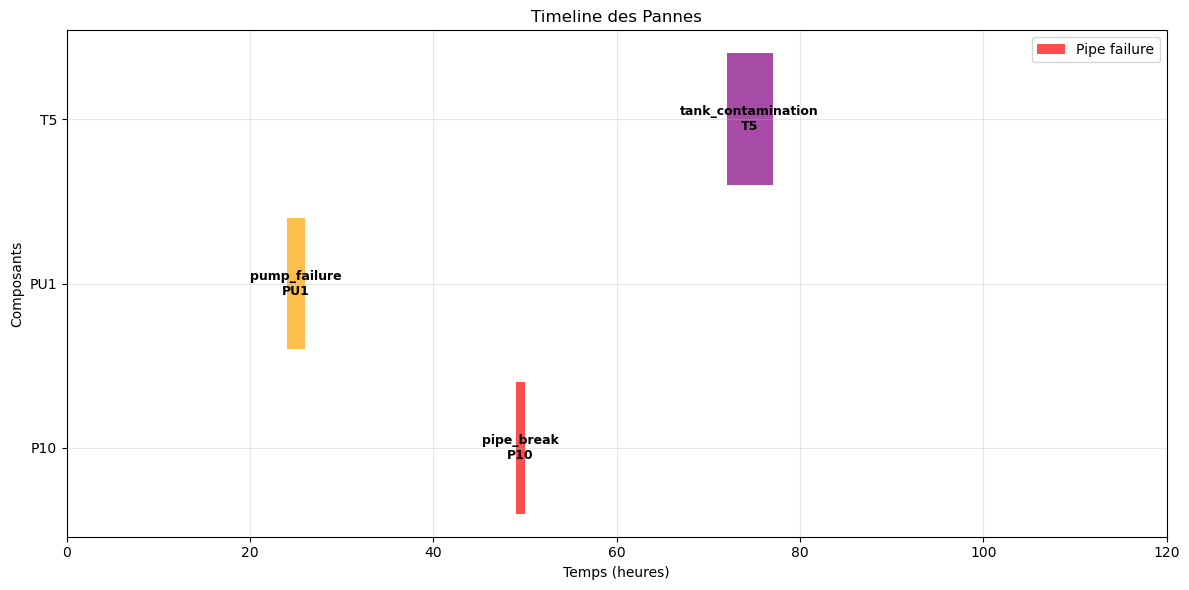


=== Simulation de référence (sans pannes) ===


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2128\1275685173.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_start = demand_starting_points.iloc[WEEK_INDEX][0]



=== Simulation avec pannes ===

=== Application des pannes ===
Panne appliquée: Conduite P10 obstruée à 50% - Scénario: pipe_break
Panne appliquée: Pompe PU1 arrêtée - Scénario: pump_failure
Panne appliquée: Réservoir T5 isolé - Scénario: tank_contamination
Running WNTR simulation with failures (PDD mode)...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2128\1275685173.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_start = demand_starting_points.iloc[WEEK_INDEX][0]



=== ANALYSE DE L'IMPACT DES PANNES ===

1. Impact sur les niveaux des réservoirs:
   T1: Niveau min normal=0.94m, avec pannes=1.00m
        Différence: 0.06m (+6.2%)
   T2: Niveau min normal=0.12m, avec pannes=0.12m
        Différence: -0.00m (-0.0%)
   T3: Niveau min normal=2.11m, avec pannes=2.11m
        Différence: 0.00m (+0.0%)
   T4: Niveau min normal=2.90m, avec pannes=2.86m
        Différence: -0.05m (-1.7%)
   T5: Niveau min normal=1.47m, avec pannes=1.47m
        Différence: 0.00m (+0.0%)
   T6: Niveau min normal=1.67m, avec pannes=1.67m
        Différence: 0.00m (+0.0%)
   T7: Niveau min normal=2.36m, avec pannes=2.41m
        Différence: 0.05m (+2.3%)

2. Impact sur les pressions de service:
   Nombre de jonctions affectées: 65/388

3. Indicateurs de performance:
   Fiabilité hydraulique: 87.6%

=== Génération des graphiques de comparaison ===


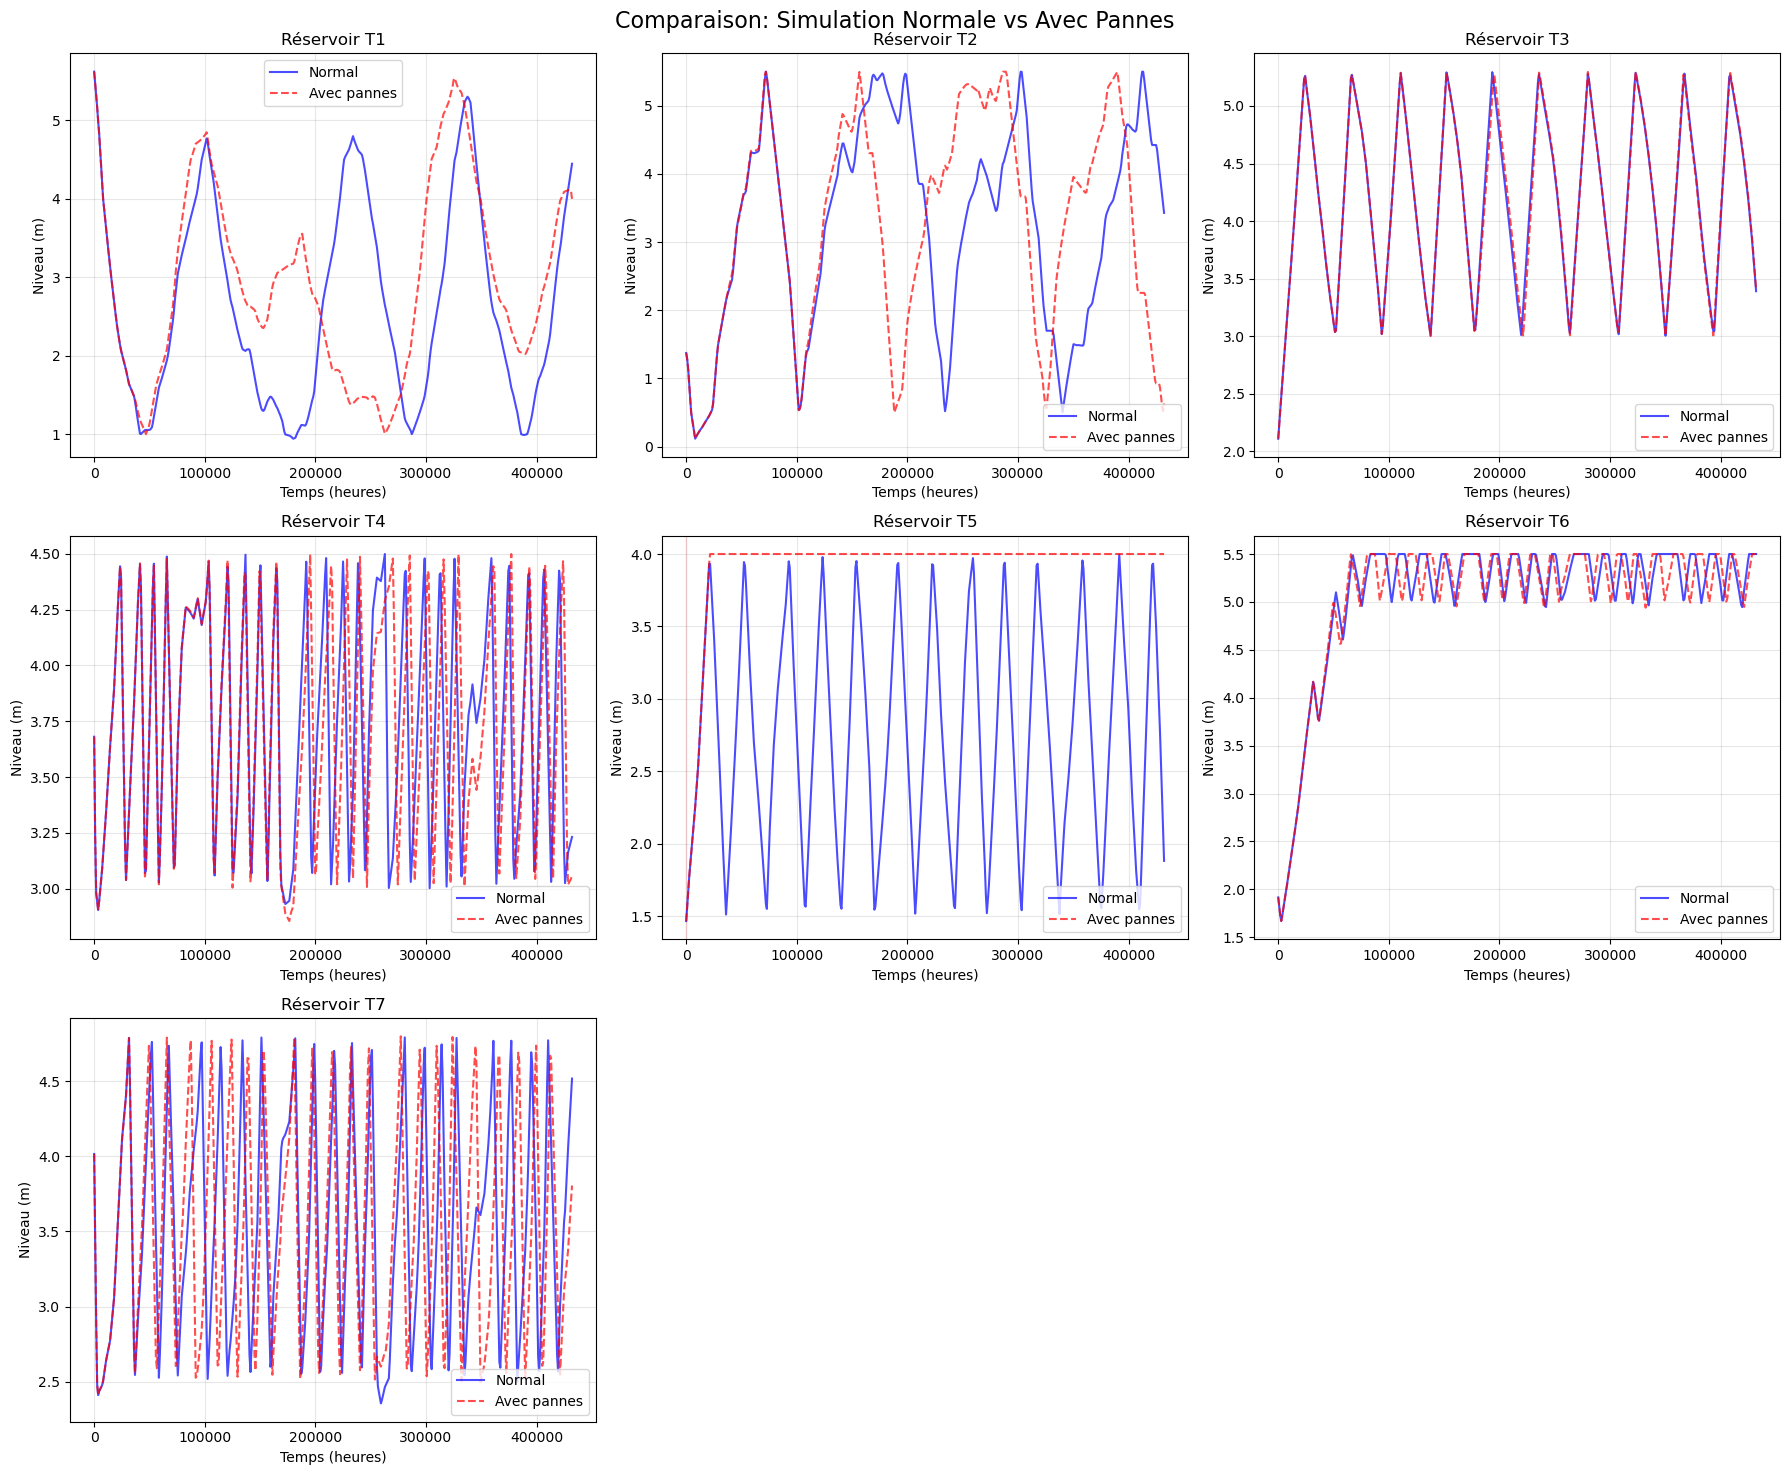


=== Sauvegarde des résultats ===
Fiabilité hydraulique finale: 87.6%
Simulation terminée avec succès!


In [28]:
########## Exécution principale ##########
if __name__ == "__main__":
    print("=== SIMULATION AVEC GESTION DES PANNES ===")
    
    # Charge le réseau
    wn_original = wntr.network.WaterNetworkModel(INP_FILE)
    
    print(f"\nRéseau chargé: {len(wn_original.junction_name_list)} jonctions, "
          f"{len(wn_original.pipe_name_list)} conduites, "
          f"{len(wn_original.pump_name_list)} pompes, "
          f"{len(wn_original.tank_name_list)} réservoirs")
    
    # Afficher la timeline des pannes
    print("\n=== Timeline des pannes prévues ===")
    create_failure_timeline(FAILURE_SCENARIOS, SIMULATION_DAYS)
    
    # Lance la simulation normale (référence)
    print("\n=== Simulation de référence (sans pannes) ===")
    normal_results = run_simulation(wn_original, use_wntr=True)
    
    # Lance la simulation avec pannes
    print("\n=== Simulation avec pannes ===")
    failure_results, failure_manager = run_simulation_with_failures(
        wn_original, 
        FAILURE_SCENARIOS, 
        use_wntr=True
    )
    
    if failure_results is not None:
        # Analyse de l'impact
        impact_metrics = analyze_failure_impact(normal_results, failure_results, FAILURE_SCENARIOS)
        
        # Visualisation comparative
        print("\n=== Génération des graphiques de comparaison ===")
        plot_failure_comparison(normal_results, failure_results, FAILURE_SCENARIOS)
        
        # Sauvegarde des résultats
        print("\n=== Sauvegarde des résultats ===")
        normal_results.node['pressure'].to_csv("normal_simulation_results.csv")
        failure_results.node['pressure'].to_csv("failure_simulation_results.csv")
        
        # Créer un rapport de synthèse
        report = {
            'simulation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'simulation_days': SIMULATION_DAYS,
            'failure_scenarios': len(FAILURE_SCENARIOS),
            'hydraulic_reliability': impact_metrics['reliability'],
            'nodes_with_pressure_issues': impact_metrics['pressure_issues'],
            'total_nodes_analyzed': impact_metrics['total_nodes_analyzed']
        }
        
        report_df = pd.DataFrame([report])
        report_df.to_csv("failure_simulation_report.csv", index=False)
        
        print(f"Fiabilité hydraulique finale: {impact_metrics['reliability']:.1f}%")
        print("Simulation terminée avec succès!")
        
    else:
        print("Erreur lors de la simulation avec pannes.")